# RC Temporal Subsampling with mixed Macro Cost

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import seaborn as sns

from ddc import YAMLParser
from sqgtools import XSQGTurb, SpectrumPlotter

In [2]:
sys.path.append("..")
from rcgfd import BigPlot

In [3]:
plt.style.use("./rc-gfd.mplstyle")

In [4]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
def read_result(n_sub, cost_terms):
    
    main_dir = "cost-"
    main_dir += "-".join(f"{k}{v:1.1e}" for k,v in cost_terms.items())
    
    dt0 = 300
    delta_t = n_sub * dt0
    out_dir = f'/contrib/Tim.Smith/qgrc-teachers/sqg/resolution/rc-temporal-sampling-064n/{main_dir}/'
    out_dir += f'validation-{delta_t:04d}dt/'
    fname = out_dir + "results.zarr"
    
    tmp = xr.open_zarr(fname, chunks={"x":16, "y":16})
    
    yp = YAMLParser()
    c = yp.read(f"{out_dir}/config-lazy.yaml")
    sd = c["preprocessing"]["norm_factor"]
    if sd is not None:
        with xr.set_options(keep_attrs=True):
            for key in ["truth", "prediction"]:
                tmp[key] = tmp[key]*sd
            
    experiment = main_dir.replace("cost-","")
    tmp = tmp.expand_dims({
        'n_sub': [n_sub],
        'experiment': [experiment]
    })
    return tmp

In [25]:
#n_samples = 50

cost_terms = {"nrmse": 1, "spectral":0.001}
dslist=[] 
n_sub = 16
for cost_terms in [
    {"nrmse":1, "spectral":0.001},
    {"nosvdinnrmse":1, "spectral":0.001},
    {"global-integral": 1},
]:
    xds = read_result(
        n_sub=n_sub,
        cost_terms=cost_terms,
    )
    dslist.append(xds)

ds = xr.concat(dslist, dim='experiment')
ds = ds.squeeze()
ds.attrs['keep_spinup'] = 'False'
ds.attrs['spinup_steps_predict'] = 0

In [26]:
ds["truth"] = ds["truth"].isel(experiment=0)
ds["error"] = ds["prediction"] - ds["truth"]

In [27]:
ds["absolute_error"] = np.abs(ds["error"])

Grab one sample for some plotting

In [48]:
xds = ds.sel(sample=3)

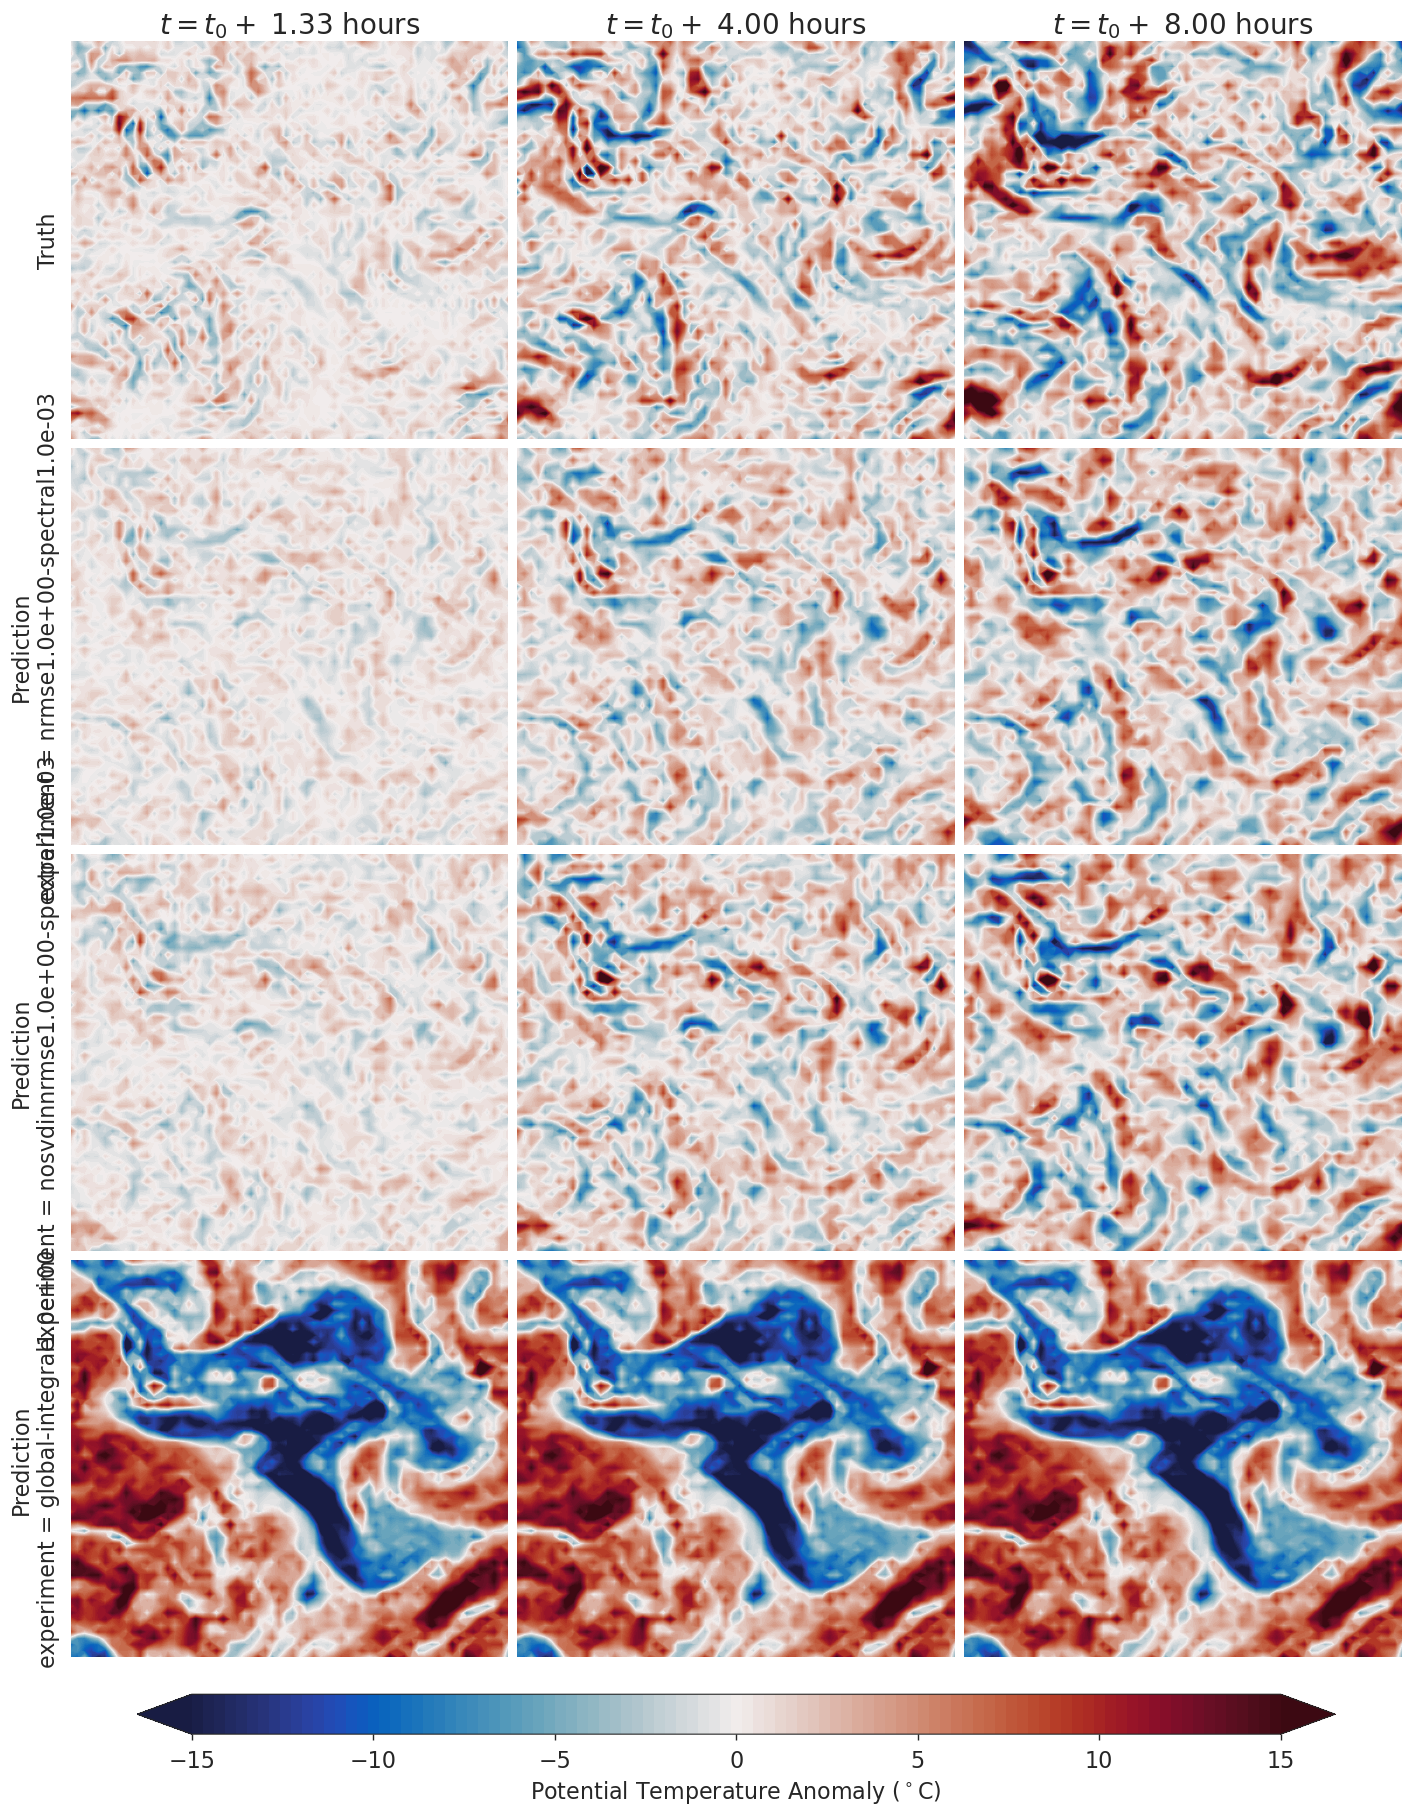

In [49]:
bp = BigPlot()
fig, axs = bp(xds, row_dim="experiment")

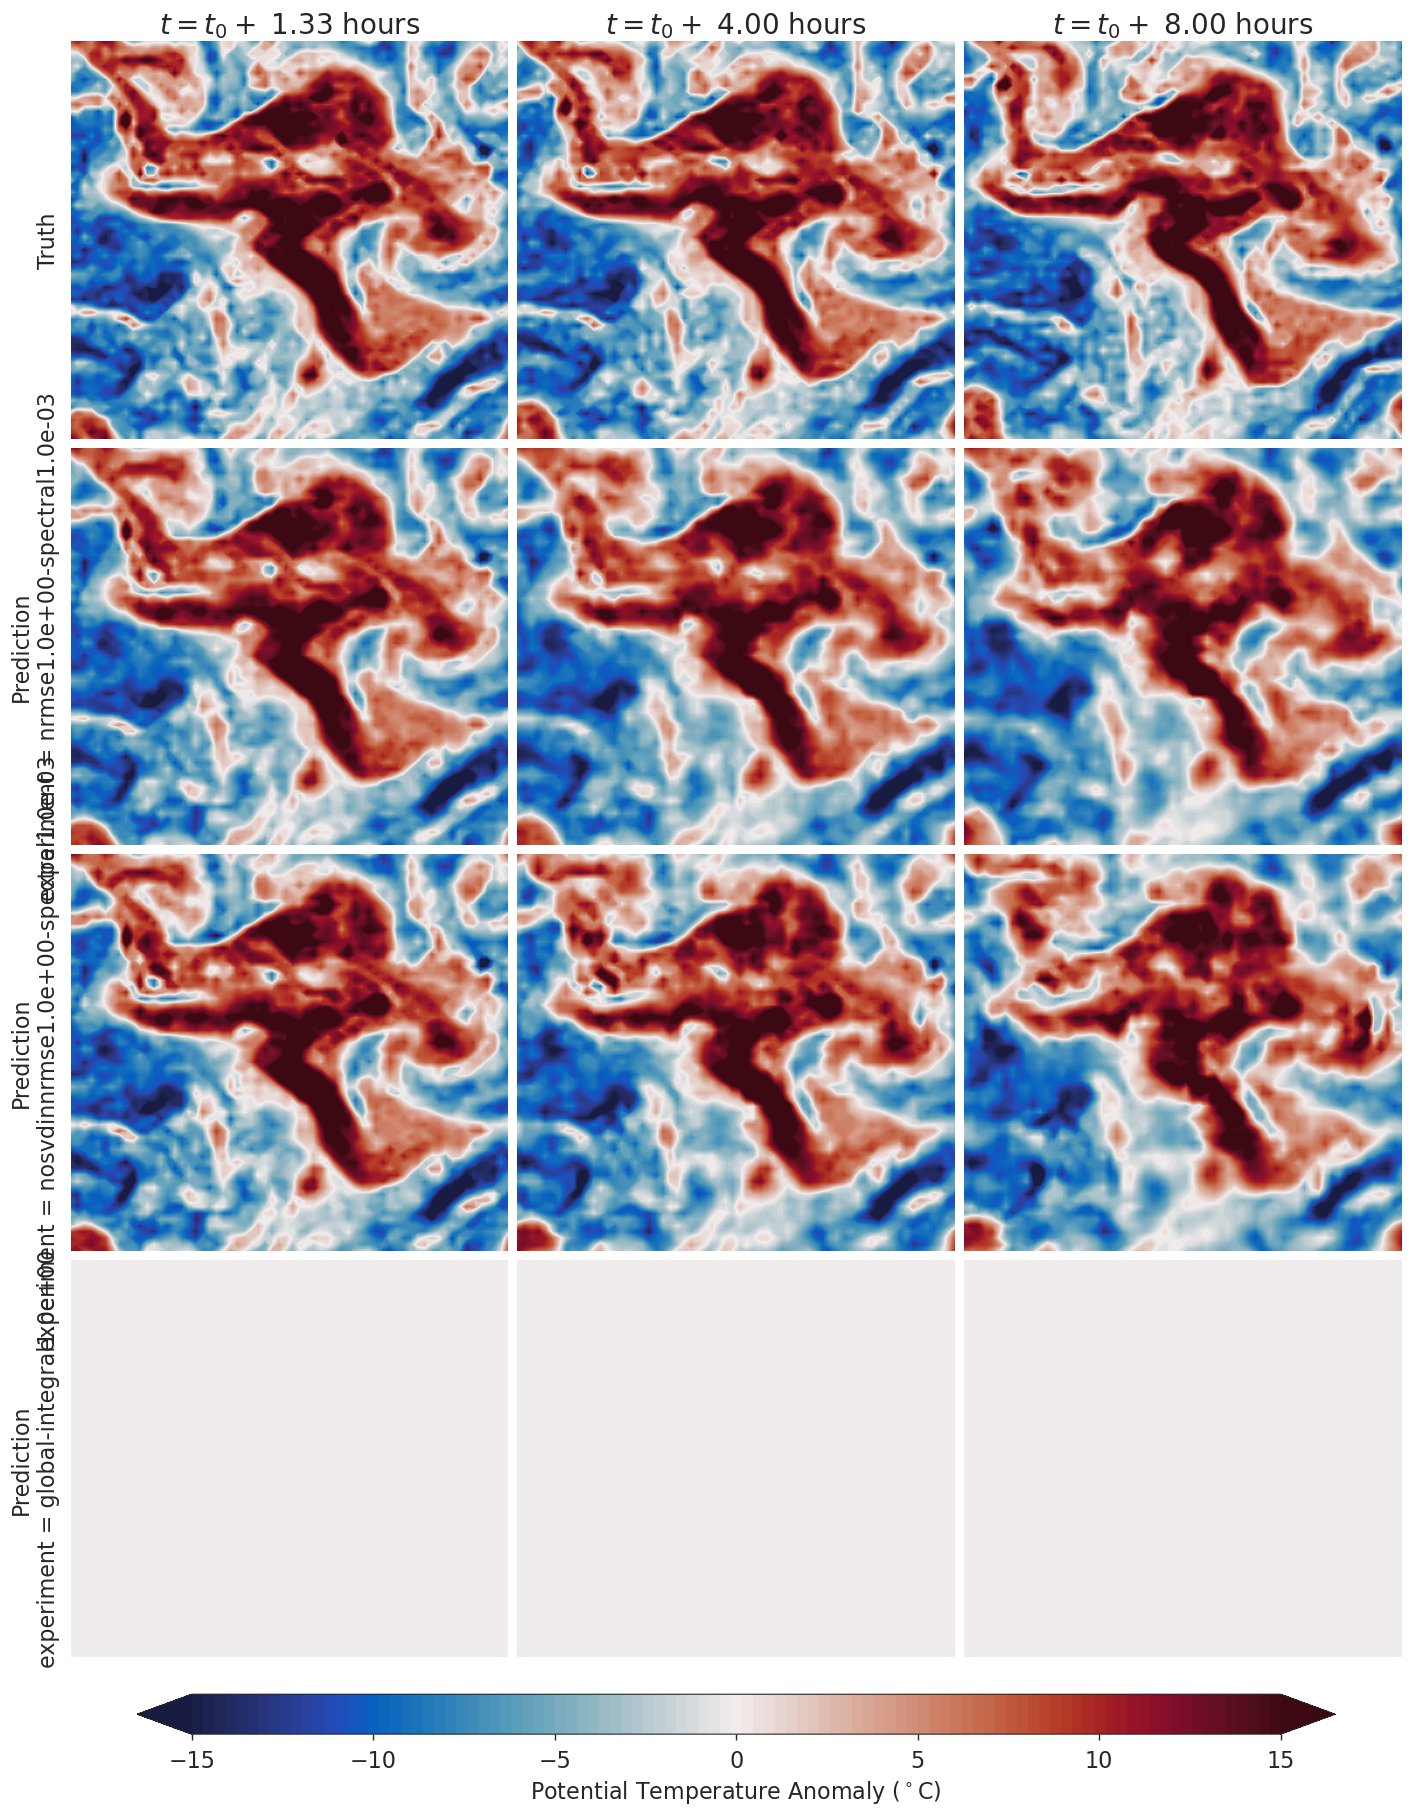

In [50]:
bp = BigPlot(diff_t0=False)
fig, axs = bp(xds, row_dim="experiment")

In [31]:
ep = BigPlot(prediction="absolute_error",
             cbar_label=r"Absolute Error ($^\circ C$)",
             cmap="viridis",
             plot_truth=False,
             vmax=10,
             vmin=0,
             subplot_kw={
                 "figsize":(14,14),
                 "constrained_layout": True,
             }
            )

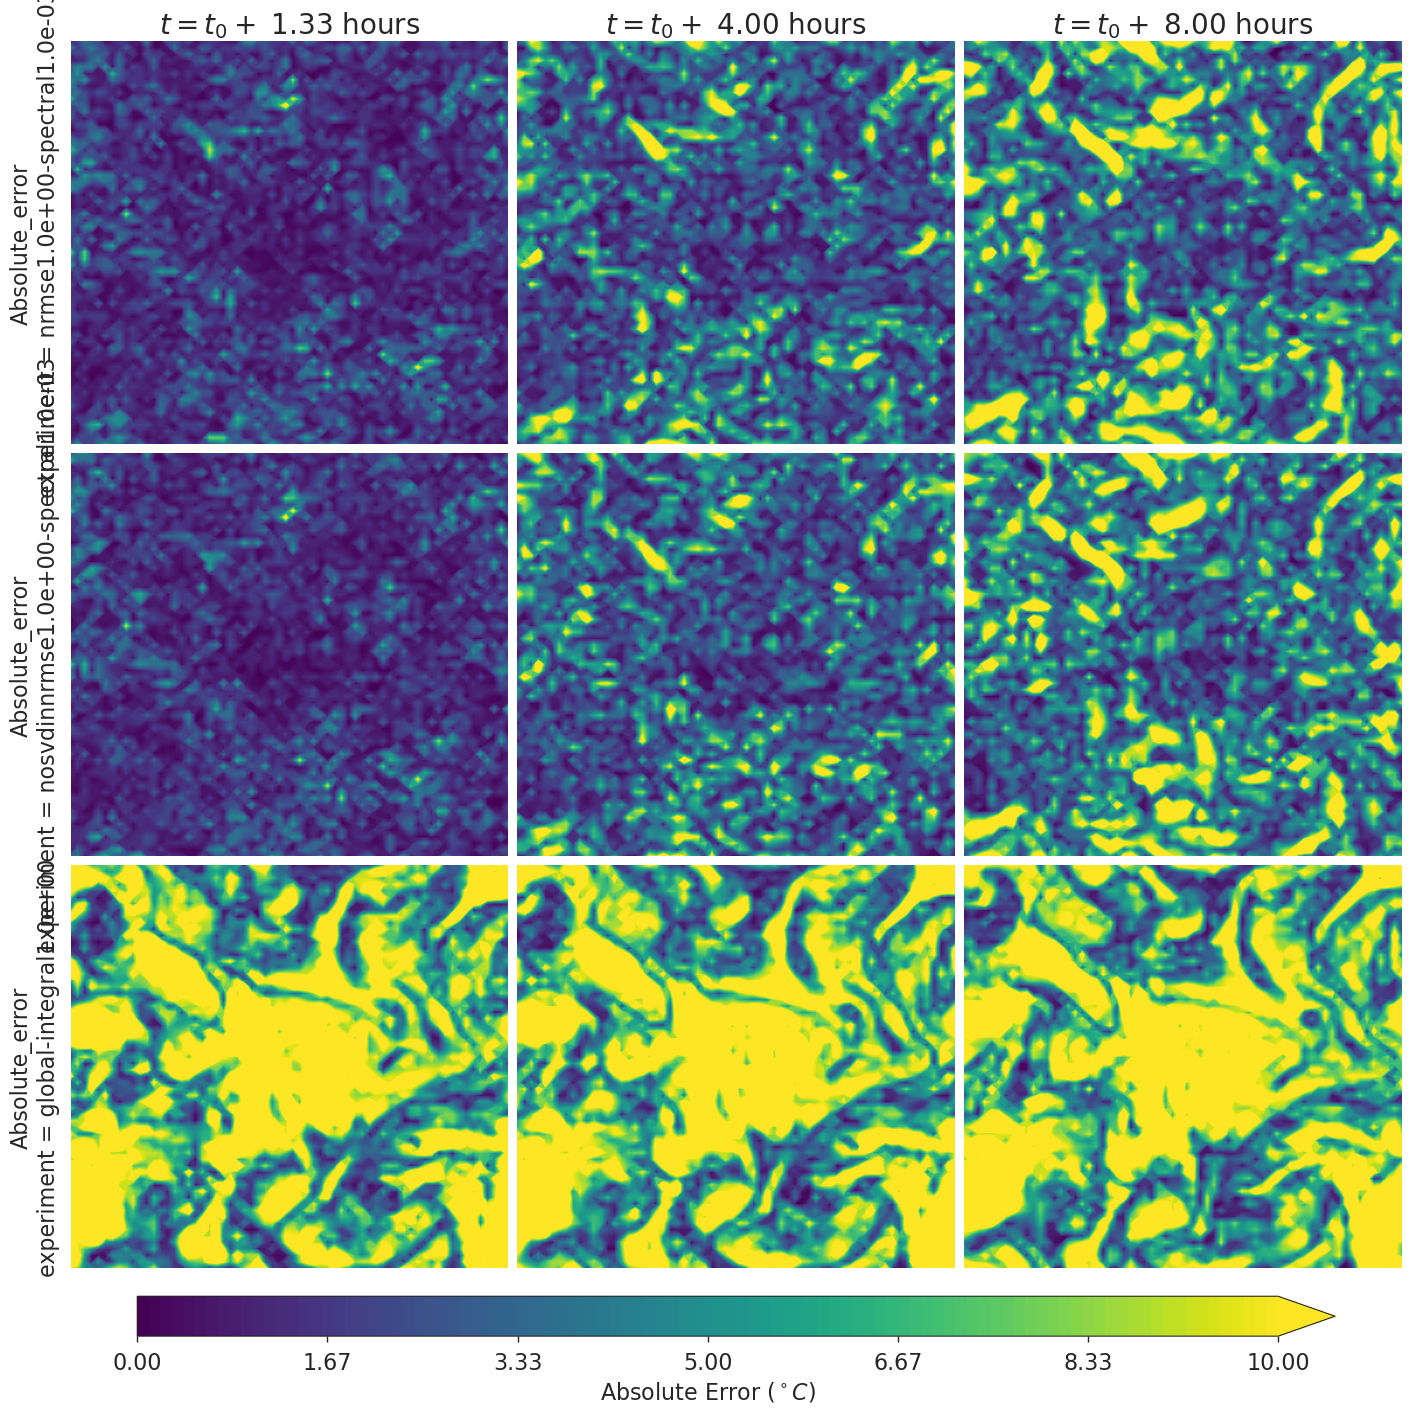

In [32]:
fig, axs = ep(xds, row_dim="experiment")

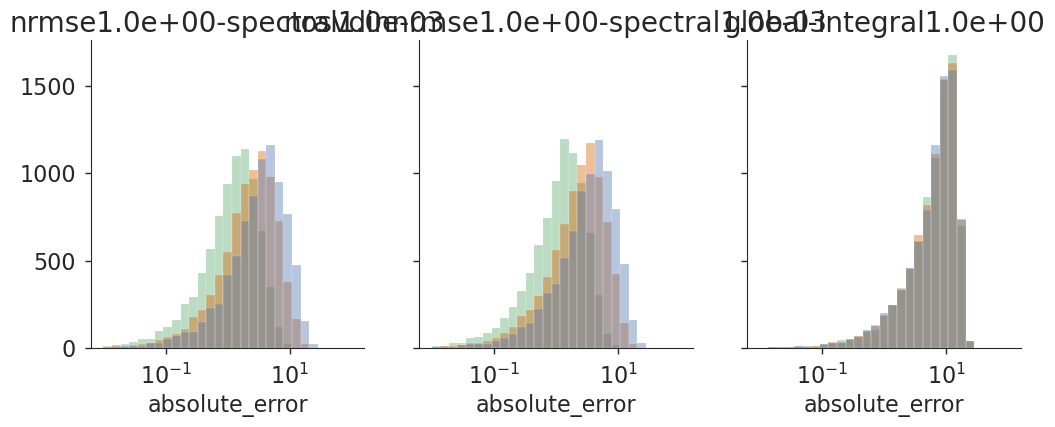

In [34]:
fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True)

bins = np.logspace(-2, 2, 30)

for experiment, ax in zip(ds.experiment.values, axs):
    for t in bp.time:
        plotme = xds.absolute_error.sel(experiment=experiment).sel(time=t)
        plotme.plot.hist(bins=bins, alpha=.4, ax=ax);
    ax.set(title=experiment)
        
    ax.set(xscale='log')

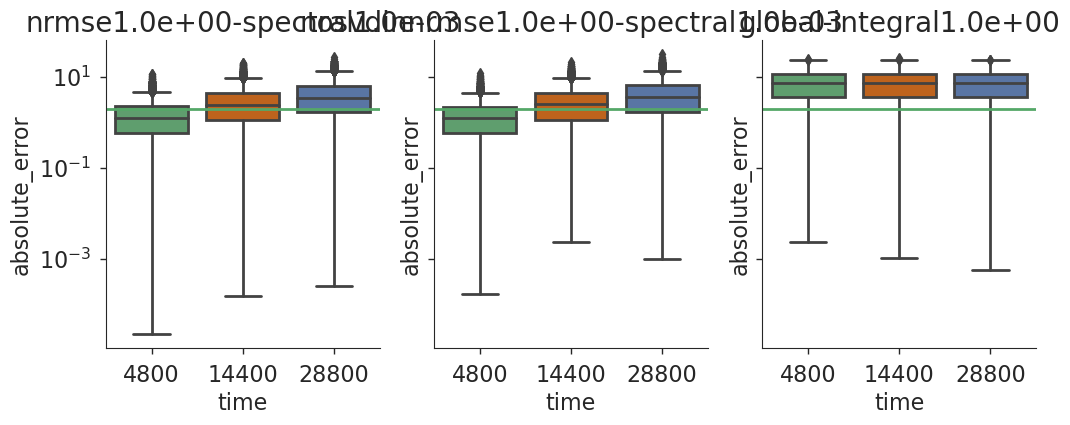

In [35]:
fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True)

bins = np.logspace(-2, 2, 30)

for experiment, ax in zip(ds.experiment.values, axs):
    plotme = xds.absolute_error.sel(experiment=experiment).sel(time=bp.time)
    sns.boxplot(
        data=plotme.to_dataframe().reset_index(),
        x="time",
        y="absolute_error",
        ax=ax,
    )
        #plotme.plot.hist(bins=bins, alpha=.4, ax=ax);
    ax.set(title=experiment, yscale='log')
    
    ax.axhline(y=2)

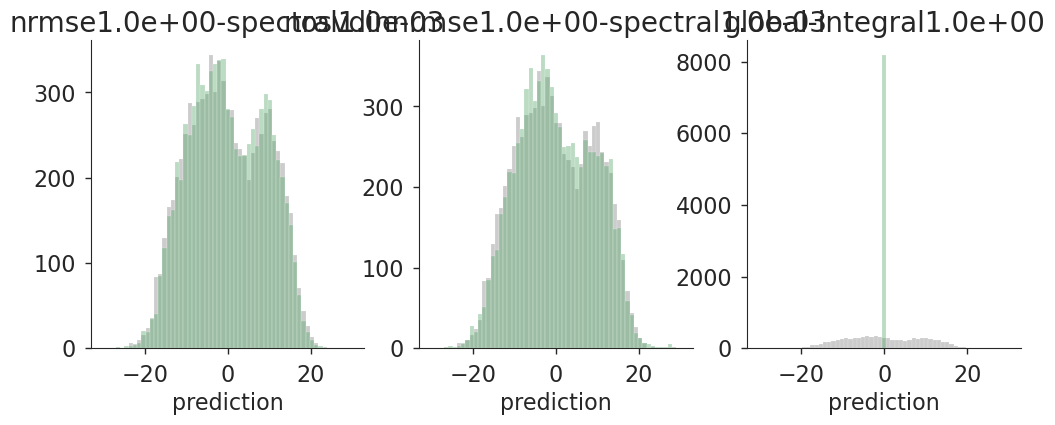

In [36]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

bins = np.linspace(-30,30,60)
#bins = np.logspace(-2, 2, 30)

for experiment, ax in zip(ds.experiment.values, axs):
    t = bp.time[-1]
    for key in ["truth", "prediction"]:
        plotme = xds[key].sel(time=t)
        if "truth" not in key:
            plotme = plotme.sel(experiment=experiment)
        color = "gray" if key == "truth" else None
        plotme.plot.hist(bins=bins, alpha=.4, ax=ax, color=color);
    ax.set(title=experiment)
        
    #ax.set(xscale='log')

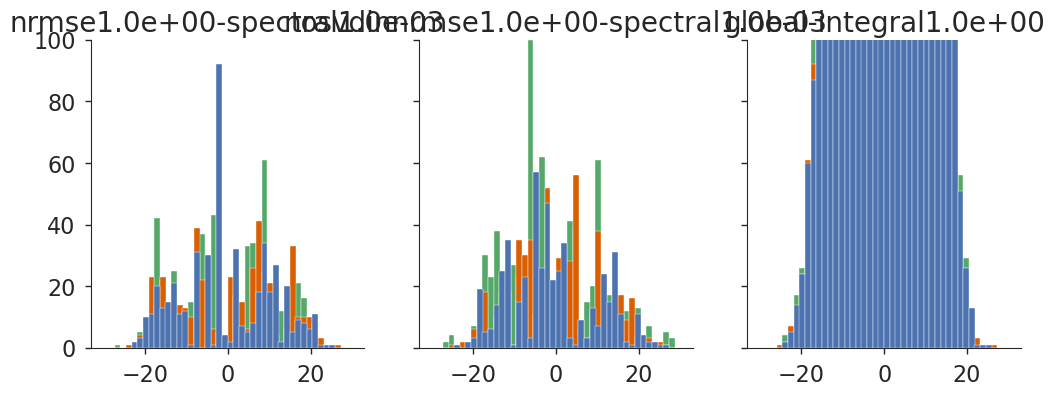

In [41]:
fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True)

bins = np.linspace(-30,30,45)
#bins = np.logspace(-2, 2, 30)

for experiment, ax in zip(ds.experiment.values, axs):
    for t in bp.time[::-1]:
        bdict = {}
        for key in ["truth", "prediction"]:
            plotme = xds[key].sel(time=t)
            if "truth" not in key:
                plotme = plotme.sel(experiment=experiment)
            bdict[key], *_ = np.histogram(plotme, bins=bins);
            bc = .5*bins[:-1] + .5*bins[1:]
            
        eb = bdict["prediction"] - bdict["truth"]
        eb = np.abs(eb)
        ax.bar(bc, eb, width=1.4)
    ax.set(title=experiment, ylim=[None,100])

## Spectra

In [42]:
time = np.arange(0,ds.time.max().values+1, 4800)
xds = ds.sel(time=bp.time)

In [43]:
xsqg = XSQGTurb()
ktrue = xsqg.calc_kespec1d(xds["truth"].load())
kpred = xsqg.calc_kespec1d(xds["prediction"].load())

In [44]:
kerr = kpred - ktrue
relerr = np.abs(kerr/ktrue)

In [45]:
sp = SpectrumPlotter(n_colors=7)
colors = sp.colors[::3]

In [46]:
from matplotlib.ticker import LogLocator

[Text(0, 0.5, 'KE Density Relative Error')]

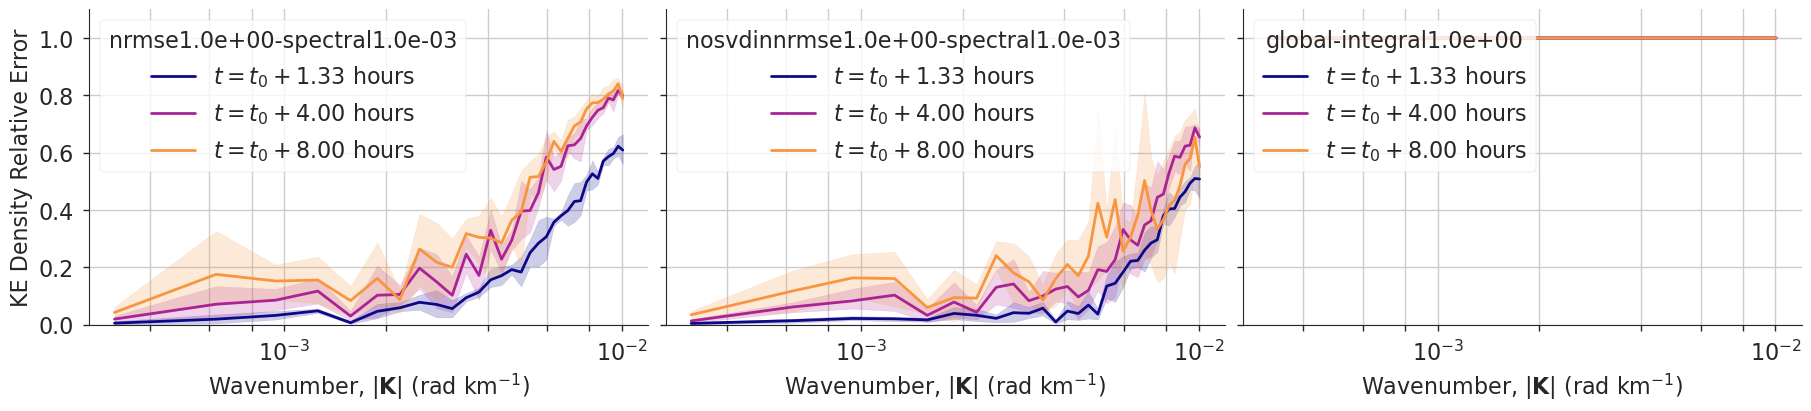

In [47]:
with plt.rc_context({"xtick.minor.size":4,"xtick.minor.width":1}):
    fig, axs = plt.subplots(1, 3, figsize=(18,4), constrained_layout=True, sharex=True, sharey=True)

for experiment, ax in zip(xds.experiment.values, axs):
    for t, c in zip(
        relerr.time,
        colors,
    ):
        plotme = relerr.sel(experiment=experiment,time=t)
        plotme=plotme.to_dataframe()
        sns.lineplot(
            data=plotme,
            x="k1d",
            y="KE Density",
            color=c,
            ax=ax,
            label="$t = t_0 + %1.2f$ hours" % float(t/3600),
        )
    
    ax.legend(
        title=experiment,
        loc="upper left",
        frameon=True,
    )
    ax.set(
        xscale="log",
        ylim=[0,1.1],
        ylabel="",
        xlabel="",
    )
    ax.xaxis.set_minor_locator(LogLocator(numticks=999, subs=(.2, .4, .6, .8)))
    ax.grid(True, which="both")
            
    ax.set(
        xlabel=r"Wavenumber, $|\mathbf{K}|$ (rad km$^{-1}$)",
    )
       
axs[0].set(ylabel="KE Density Relative Error")
#fig.savefig(f"{fig_dir}/nvar_big_ke_relerr.pdf", bbox_inches="tight")

## Global Integral

[Text(0, 0.5, 'Global Integral')]

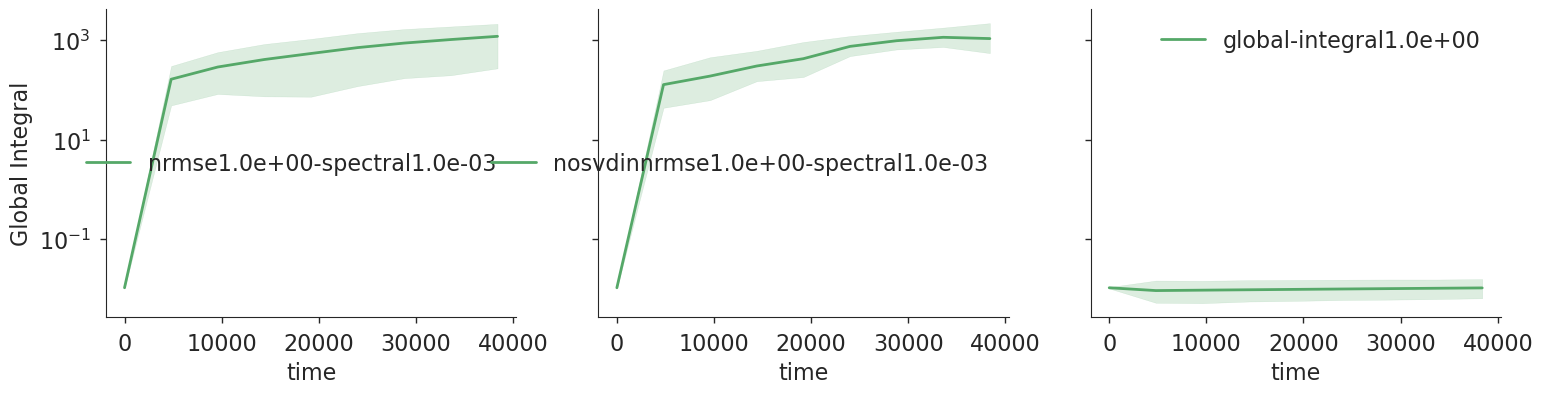

In [64]:
fig, axs = plt.subplots(1,3, figsize=(18,4), sharey=True)

for experiment, ax in zip(ds.experiment.values, axs):
    dims = ("x", "y", "z")
    plotme = ds["prediction"].sel(experiment=experiment).sum(dims)
    plotme = np.abs(plotme)
    plotme=plotme.to_dataframe()
    sns.lineplot(
        data=plotme,
        x="time",
        y="prediction",
        ax=ax,
        label=experiment)
    
    ax.set(yscale="log")
    
axs[0].set(ylabel="Global Integral")